# RVS Generator
## Authors: Alok Suresh, Chang Liu and Youngjun Cho
## UCL Computer Science
### Reference: Cho, Y., Bianchi-Berthouze, N., & Julier, S. J. (2017, October). DeepBreath: Deep learning of breathing patterns for automatic stress recognition using low-cost thermal imaging in unconstrained settings. In 2017 Seventh International Conference on Affective Computing and Intelligent Interaction (ACII) (pp. 456-463). IEEE.

# Setup Workspace

In [ ]:
#load packages
import scipy
from scipy import signal
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import time
from IPython import display
from scipy.io import loadmat
import itertools
from itertools import combinations
import math

import pickle 
from scipy import fftpack
import cv2
from astropy.timeseries import LombScargle
from IPython.display import Audio, display
import PIL
from PIL import Image

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import torch
from torchvision import transforms
from torchvision.transforms import Normalize, Resize, ToTensor


# Load Signal Arrays

In [ ]:
#Make dictionary of singal names and corresponding array index
nums = [x for x in range(1,33,1)]
signal_names =  ['Resp']
index = [x for x in range(40)]
signal_dict = dict(zip(signal_names, index))

In [ ]:
#Load spectrograms
filename='yourown file name'

def get_f(participant):
  with open(filename.format(participant), 'rb') as f:
      u = pickle._Unpickler(f)
      u.encoding = 'latin1'
      p = u.load()
    
  return np.asarray(p['data'])


all_resp = []
resp_dict = {}

#Save spectrograms for each participant into seperate arrays
for i in np.arange(1,33,1):
  if i < 10:
    part = '0'+str(i)
  else:
    part = str(i)
    
  resp_dict.update({part : []})

  data = get_f(part)
  resp_ind = signal_dict['Resp']
  all_resp.append(data[:,resp_ind])

all_resp_array = np.stack(all_resp)

print(all_resp_array.shape)

#Reshape arrays to 32 x 40 = 1280 (total num  samples)
all_resp_reshape = np.reshape(all_resp_array, (1280,8064))

print(all_resp_reshape.shape)

(32, 40, 8064)
(32, 40, 8064)
(1280, 8064)
(1280, 8064)


# Spectrogram Generation

In [ ]:
#Overlapping sliding window
def overlap_windows(data,overlap_rate,window_size):
    window_list = []
    start = 0
    end = window_size
    remain_length = len(data)
    
    while remain_length>=window_size:
        window_list.append(data[int(round(start+0.01)):int(round(end+0.01))])
        start += overlap_rate*window_size #start and end overlap 1
        end += overlap_rate*window_size
        remain_length -= overlap_rate*window_size 
    
    return window_list

#Gaussian window function
def gausswin(L, alpha=2.5):
    N = L - 1
    n = np.arange(0,N+1)-N/2
    w = np.exp(-(1/2)*(alpha*n /(N /2))**2)
    return w


In [ ]:
#single rvs
def rvs_single(Fss,x0):#t0: #7.5

    #Define spectroram parameters
    Tmax = 7.5
    lag = Tmax*Fss #samples per sec x sec'

    #Retreive list of windowed signal segments
    window_list = overlap_windows(x0,0.05,lag) #0.01

    s_PSD_1 = []

    print("Num windows :", len(window_list))

    #Cyclye over each windowed segement of current signal
    for i in range(len(window_list)):

        #Min-max normalise signal data 
        data_use = window_list[i]
        data_info = data_use.copy() #shallow copy

        max_data = max(data_info)
        min_data = min(data_info)
        for j in range(len(data_info)):
            data_info[j] = (data_info[j]-min_data)/(max_data-min_data)

        #Filter paramters
        filterN = 3 
        Wn1=0.8
        Wn2=2.3
        Fn=128/2

        #Band pass filter signal using elliptic filter 
        filter_b, filter_a = scipy.signal.ellip(filterN,3,6,[Wn1/Fn,Wn2/Fn],btype='bandpass')
        filtered_featurescaled_data = scipy.signal.lfilter(filter_b,filter_a,data_info,axis=0)
        w = gausswin(lag) #335

        #Convolve with gaussian
        gaussian_final_window = np.array(filtered_featurescaled_data*w.T,dtype='float64')
    
        #Compute periodogram of signal data
        t = np.arange(0, (len(gaussian_final_window))/Fss, 1/Fss)
        dy = 0.1
        frequency, freq_amplitude = LombScargle(t, gaussian_final_window, dy).autopower(
                                                   samples_per_peak=150)
        #print(frequency.shape)
        #print(freq_amplitude.shape)
        #STACK PSD IN SLIDING WNNDOW
        s_PSD_1.append(freq_amplitude[0:2000])

    s_PSD_1 = np.array(s_PSD_1).T
    ss_PSD_1=s_PSD_1[:,:]

    return ss_PSD_1    

In [ ]:
start_time = time.time()
parts = list(resp_dict.keys())

#Generate spectrograms for each participant 
count = 0
gen_specs = []

#3, 2:3
#6, 14:15
for sig in all_resp[0][0:1]:
  print("Generating for Video",count+1,"...")
  spectrogram = rvs_single(128,sig)
  gen_specs.append(spectrogram)
  count += 1

print("Process finished --- %s seconds ---" % ((time.time() - start_time)))

Generating for Video 1 ...
Num windows : 149
Process finished --- 76.23115825653076 seconds ---


# Spectrogram Resizing

## Original Resize (80 x 80)

In [ ]:
#Set target dimensions for resize 
composed = transforms.Compose([ Resize(size=(120,120)),
                                ToTensor()])

#Resize spectrogram for current participant
spec_list = []
for resp_spec in gen_specs:
  print(resp_spec.shape)
  out2 = composed(Image.fromarray(resp_spec))
  out2 = np.transpose(out2.data.numpy(), (1, 2, 0))
  out2 = out2[:,:,0]
  spec_list.append(out2)

#Save spectrograms in seperate np file for each particiapnt
spec_array = np.stack(spec_list)
np.save('20resp_spec_21.npy', spec_array)

(2000, 149)


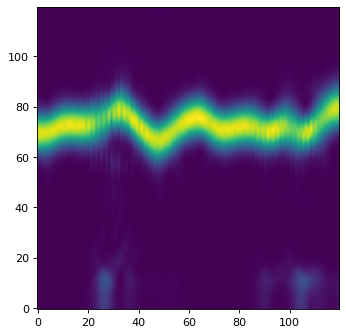

In [ ]:
#View samples of spectograms 
test_spec = np.load('20resp_spec_21.npy')

for i in range(len(test_spec)):
  plt.figure(figsize=(8,5), dpi= 80, facecolor='w', edgecolor='k')
  plt.imshow(test_spec[i],origin='lower')
  plt.show()
  
